In [ ]:
# Adding src to the path for modules
import sys
import os
root_path = os.path.abspath('..')
src_path = os.path.join(root_path, 'src')
sys.path.append(src_path)

# Data manipulation
import pandas as pd
import numpy as np

# hypothesis testing
from scipy.stats import stats

# Preliminary training and evaluation
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Project variables and functions
import config 
import utils
import importlib
importlib.reload(utils)

In [2]:
# Importing data 
df = utils.read_compressed_data(config.COLLECTED_DATA_PATH)

# Defining X and y
features = [col for col in df.columns if 'income' not in col] # all columns that don't have the word income
X = df[features]
y = df['all_work_income']

# Dividing into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=.25)

# Checking split
print(X_train.head())
print(y_train.head())

       state  age  sex  race  literate  highest_educational_level  \
421961    PR   19    1     4         1                          5   
394408    SC   55    1     1         1                          5   
540496    SC   58    2     1         1                          5   
618928    AC   48    2     1         1                          7   
569213    SE   29    1     4         1                          5   

        years_studied  worker_type  work_segment  occupation_group  tax_payer  \
421961             12            7             8                10          1   
394408             12            7             8                 8          1   
540496             12            1             7                 9          1   
618928             15            1             7                 1          1   
569213             12            1             4                 5          1   

        weekly_worked_hours  weekly_worked_hours_all_jobs  
421961                    3           

In [3]:
# Creates pipeline to transform state
pipeline = Pipeline(
    steps=[
        ('state_encoded', OrdinalEncoder())
    ]
)

# Specifies the only column to be transformed
transformer = ColumnTransformer(
    transformers=[
        ('state_transformer', pipeline, ['state'])
    ],
    remainder='passthrough'
)

# Joins pipeline and baseline model
baseline = Pipeline(
    steps=[
        ('transform_state', transformer),
        ('model', RandomForestRegressor(random_state=0))
    ]
)

In [18]:
# Train baseline model
baseline.fit(X_train, y_train)

# Predicts
baseline_predictions = baseline.predict(X_test)

# Scoring
test_r2 = r2_score(y_test, baseline_predictions)
test_mae = mean_absolute_error(y_test, baseline_predictions)
test_mse = mean_squared_error(y_test, baseline_predictions)

# Print scores
print(f'Test R² score {test_r2}')
print(f'Test MAE score {test_mae}')
print(f'Test MSE score {test_mse}')

Test R² score 0.34505023476931007
Test MAE score 1257.1443896414407
Test MSE score 11420964.945808362


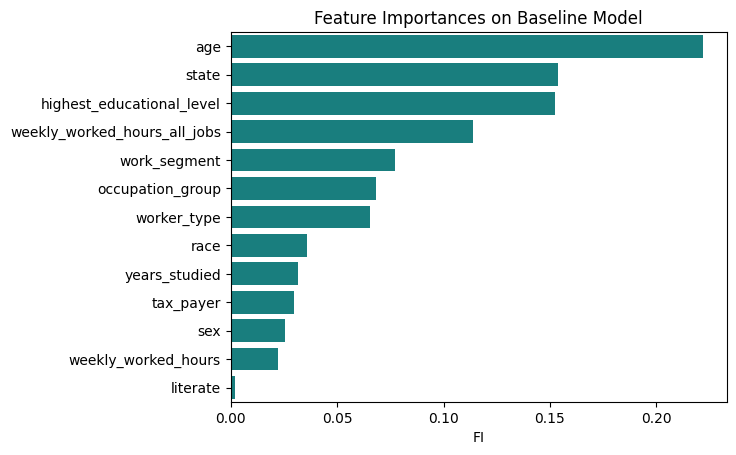

In [21]:
feature_importances = pd.Series(baseline['model'].feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False, inplace=True)
utils.show_barplot(feature_importances.index, feature_importances, 'Feature Importances on Baseline Model', 'FI')

In [ ]:
cv = [score * -1 for score in cross_val_score(baseline, X, y, cv=10, scoring='neg_mean_absolute_error')]

In [28]:
print(f'Mean MAE: R$ {np.mean(cv) :.2f}')
print(f'Std MAE: R$ {np.std(cv) :.2f}')

Mean MAE: R$ 1378.29
Std MAE: R$ 958.33


_____
Testing feature selection by selection less features and comparing model performance

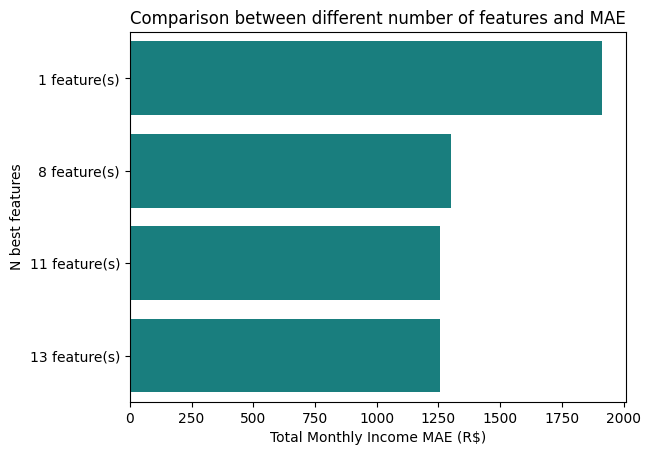

In [22]:
# Creates list of features ranked by feature importance in the baseline model
feature_importances_baseline = ['age', 'state', 'highest_educational_level', 'weekly_worked_hours_all_jobs', 'work_segment', 'occupation_group', 
                                'worker_type', 'race', 'years_studied', 'tax_payer', 'sex', 'weekly_worked_hours', 'literate']

# Initializing variables to aid in the search
baseline_mae = 1257 # all features performance rounded to the next integer
rfr = RandomForestRegressor(random_state=0)

def less_features_predict(features_subset):
    X_train_subset = X_train[features_subset]
    X_test_subset = X_test[features_subset]

    if 'state' in features_subset:
        baseline.fit(X_train_subset, y_train)
        preds = baseline.predict(X_test_subset)
        return mean_absolute_error(y_test, preds)
    else:
        rfr.fit(X_train_subset, y_train)
        preds = rfr.predict(X_test_subset)
        return mean_absolute_error(y_test, preds)

def feature_length_selection(ranked_feature_importance: list, baseline_mae: int):
    """This function takes a ranked_feature_importance list, and a baseline MAE to test if reducing the number of feature can reduce the baseline MAE"""
    min_features = 1 # best feature in the ranked list
    max_features = len(ranked_feature_importance)
    maes = pd.Series(dtype=int) # empty series to store different maes
    while min_features < max_features:
        candidate_features = ranked_feature_importance[:min_features]
        candidate_mae = int(less_features_predict(candidate_features))

        # Stores the calculated mae for the number of features used
        maes[f'{min_features} feature(s)'] = candidate_mae

        # defines the middle
        mid = (min_features + max_features) // 2

        if candidate_mae >= baseline_mae:
            min_features = mid + 1 
        else:
            max_features = mid - 1
            baseline_mae = candidate_mae
    
    return maes

feature_importances_check = feature_length_selection(feature_importances_baseline, baseline_mae)
utils.show_barplot(
    cat = feature_importances_check.index,
    values = feature_importances_check,
    title = 'Comparison between different number of features and MAE',
    y_label = 'N best features',
    x_label = 'Total Monthly Income MAE (R$)'
)

Adding feature comparition for MI scores in the eda.ipynb

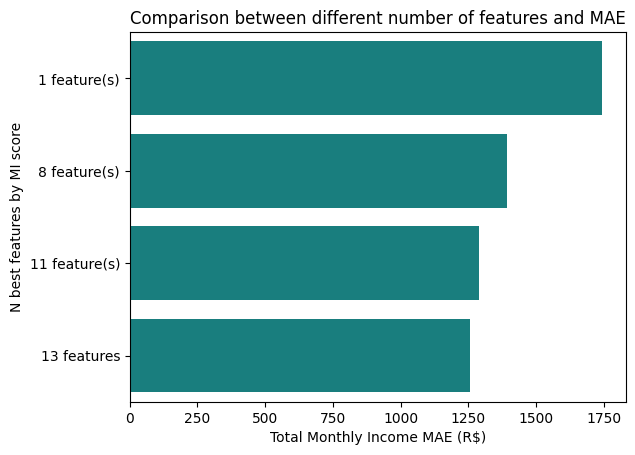

In [5]:
# Creates list of features ranked by feature importance in the baseline model
ranked_mi_features = ['worker_type', 'occupation_group', 'tax_payer', 'weekly_worked_hours_all_jobs', 'highest_educational_level', 'years_studied', 
                      'weekly_worked_hours', 'work_segment', 'state', 'age', 'race', 'literate', 'sex']

# Initializing variables to aid in the search
baseline_mae = 1257 # all features performance rounded to the next integer
rfr = RandomForestRegressor(random_state=0)

def less_features_predict(features_subset):
    X_train_subset = X_train[features_subset]
    X_test_subset = X_test[features_subset]

    if 'state' in features_subset:
        baseline.fit(X_train_subset, y_train)
        preds = baseline.predict(X_test_subset)
        return mean_absolute_error(y_test, preds)
    else:
        rfr.fit(X_train_subset, y_train)
        preds = rfr.predict(X_test_subset)
        return mean_absolute_error(y_test, preds)

def feature_length_selection(ranked_feature_importance: list, baseline_mae: int):
    """This function takes a ranked_feature_importance list, and a baseline MAE to test if reducing the number of feature can reduce the baseline MAE"""
    min_features = 1 # best feature in the ranked list
    max_features = len(ranked_feature_importance)
    maes = pd.Series(dtype=int) # empty series to store different maes
    while min_features < max_features:
        candidate_features = ranked_feature_importance[:min_features]
        candidate_mae = int(less_features_predict(candidate_features))

        # Stores the calculated mae for the number of features used
        maes[f'{min_features} feature(s)'] = candidate_mae

        # defines the middle
        mid = (min_features + max_features) // 2

        if candidate_mae >= baseline_mae:
            min_features = mid + 1 
        else:
            max_features = mid - 1
            baseline_mae = candidate_mae
    
    return maes

ranked_mi_check = feature_length_selection(ranked_mi_features, baseline_mae)
ranked_mi_check['13 features'] = 1257
utils.show_barplot(
    cat = ranked_mi_check.index,
    values = ranked_mi_check,
    title = 'Comparison between different number of features and MAE',
    y_label = 'N best features by MI score',
    x_label = 'Total Monthly Income MAE (R$)'
)

It looks like the best number for features is between 11-13. If we consider the worst features in both criteria, we could probably remove **literate** and **weekly_worked_hours** since they add little information to the model.
______

Testing a boosting algotithm as baseline

In [7]:
from sklearn.ensemble import GradientBoostingRegressor

# Creates pipeline to transform state
alt_pipeline = Pipeline(
    steps=[
        ('state_encoded', OrdinalEncoder())
    ]
)

# Specifies the only column to be transformed
alt_transformer = ColumnTransformer(
    transformers=[
        ('state_transformer', alt_pipeline, ['state'])
    ],
    remainder='passthrough'
)

# Joins pipeline and baseline model
alt_baseline = Pipeline(
    steps=[
        ('transform_state', alt_transformer),
        ('model', GradientBoostingRegressor(random_state=0))
    ]
)

In [8]:
# Train baseline model
alt_baseline.fit(X_train, y_train)

# Predicts
alt_baseline_predictions = alt_baseline.predict(X_test)

# Scoring
test_r2 = r2_score(y_test, alt_baseline_predictions)
test_mae = mean_absolute_error(y_test, alt_baseline_predictions)
test_mse = mean_squared_error(y_test, alt_baseline_predictions)

# Print scores
print(f'Test R² score {test_r2}')
print(f'Test MAE score {test_mae}')
print(f'Test MSE score {test_mse}')

Test R² score 0.30863137533494434
Test MAE score 1344.551824159931
Test MSE score 12056034.288599424


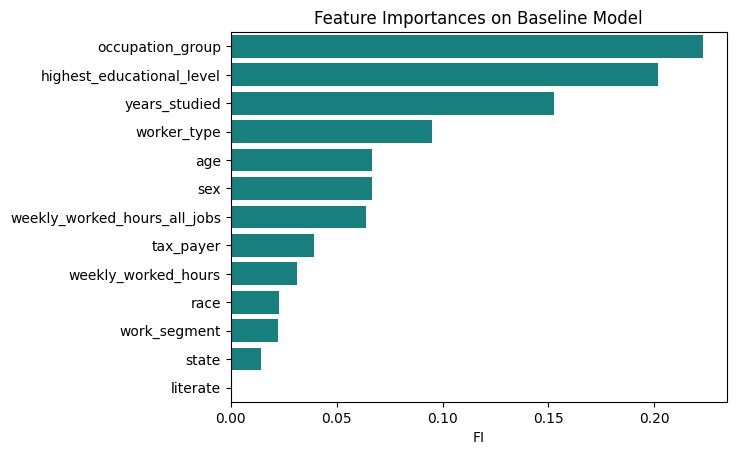

In [9]:
feature_importances = pd.Series(alt_baseline['model'].feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False, inplace=True)
utils.show_barplot(feature_importances.index, feature_importances, 'Feature Importances on Baseline Model', 'FI')

______
Testing impact of Winsorization on MAE

In [12]:
from sklearn.preprocessing import FunctionTransformer
from scipy.stats.mstats import winsorize

# Creates function for winsorization
def winsorizes_y(y, limits=[0.0, 0.05]):
    return winsorize(y, limits=limits)

# Creates pipeline to transform state
pipeline = Pipeline(
    steps=[
        ('state_encoded', OrdinalEncoder())
    ]
)

# Specifies the only column to be transformed
transformer = ColumnTransformer(
    transformers=[
        ('state_transformer', pipeline, ['state'])
    ],
    remainder='passthrough'
)

# Joins pipeline and baseline model
baseline = Pipeline(
    steps=[
        ('transform_state', transformer),
        ('winsorizes_target', FunctionTransformer(lambda y: winsorizes_y(y))),
        ('model', RandomForestRegressor(random_state=0))
    ]
)

In [24]:
# Train baseline model
baseline.fit(X_train, y_train)

# Predicts
baseline_predictions = baseline.predict(X_test)

# Winsorizes y_test
y_test_winsorized = winsorizes_y(y_test)

# Scoring
test_r2 = r2_score(y_test_winsorized, baseline_predictions)
test_mae = mean_absolute_error(y_test_winsorized, baseline_predictions)
test_mse = mean_squared_error(y_test_winsorized, baseline_predictions)

# Print scores
print(f'Test R² score {test_r2}')
print(f'Test MAE score {test_mae}')
print(f'Test MSE score {test_mse}')

Test R² score -0.5730832363902754
Test MAE score 1114.5596989141577
Test MSE score 5997851.117450167
